In [3]:
import os, sys

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from nbafuns import *
from nba_api.stats.endpoints import leaguedashteamstats

img_DIR_T = "../data/images/teams/"
fig_DIR = "../figs/teams/"
box_DIR = "../data/box/"

In [2]:
cols1 = ['TEAM_NAME', 'GP', 'W', 'L', 'W_PCT',
       'OFF_RATING', 'DEF_RATING', 'NET_RATING', 'EFG_PCT', 'TS_PCT', 'E_PACE', 'PACE', 'POSS',
       "W_RANK", "L_RANK",
       'W_PCT_RANK', 'OFF_RATING_RANK', 'DEF_RATING_RANK',
       'NET_RATING_RANK',]

In [4]:
dfa = []
for year in range(2014,2024):
    stats = leaguedashteamstats.LeagueDashTeamStats(
        measure_type_detailed_defense="Advanced",
        season_type_all_star="Playoffs",
        season=get_ss(year)
    )
    df2 = stats.get_data_frames()[0]
    df2 = df2.sort_values("W",ascending=False).reset_index(drop=True)
    df3 = df2[cols1]
    df3["season"] = year + 1
    time.sleep(0.6)
    stats = leaguegamelog.LeagueGameLog(
        player_or_team_abbreviation="T",
        season=get_ss(year),
        season_type_all_star="Playoffs",
    )
    df4 = stats.get_data_frames()[0]
    df4["Round"] = df4["GAME_ID"].str[-3]
    df4["Win"] = df4["WL"] == "W"
    df4["Loss"] = df4["WL"] == "L"
    df5 = df4.groupby(["TEAM_NAME","Round"])[["Win","Loss"]].sum().reset_index()
    df6 = df5.groupby(["TEAM_NAME"])[["Round"]].count().reset_index()
    df7 = pd.merge(df3,df6,on="TEAM_NAME",how="left")
    dfa.append(df7)
    time.sleep(0.6)
df8 = pd.concat(dfa)

In [7]:
qus = ["Round == 0","Round == 1","Round == 2","Round == 3","Round == 4 & W_RANK == 2","Round == 4 & W_RANK == 1"]
scenario = ["Miss Playoffs","1st Round","2nd Round","Conf Finals","Finals","Championship"]
scenario_dict = {"Miss Playoffs":0,"1st Round":1,"2nd Round":2,"Conf Finals":3,"Finals":4,"Championship":5}
dfb = []
for q,s in zip(qus,scenario):
    df9 = df8.query(q)
    df9["scenario"] = s
    dfb.append(df9)
df10 = pd.concat(dfb)
df11 = df10[["TEAM_NAME","season","scenario"]]
# df11["scenario"] = pd.Categorical(df11["scenario"],categories=scenario,ordered=True) 

In [8]:
from plotnine import scale_y_discrete

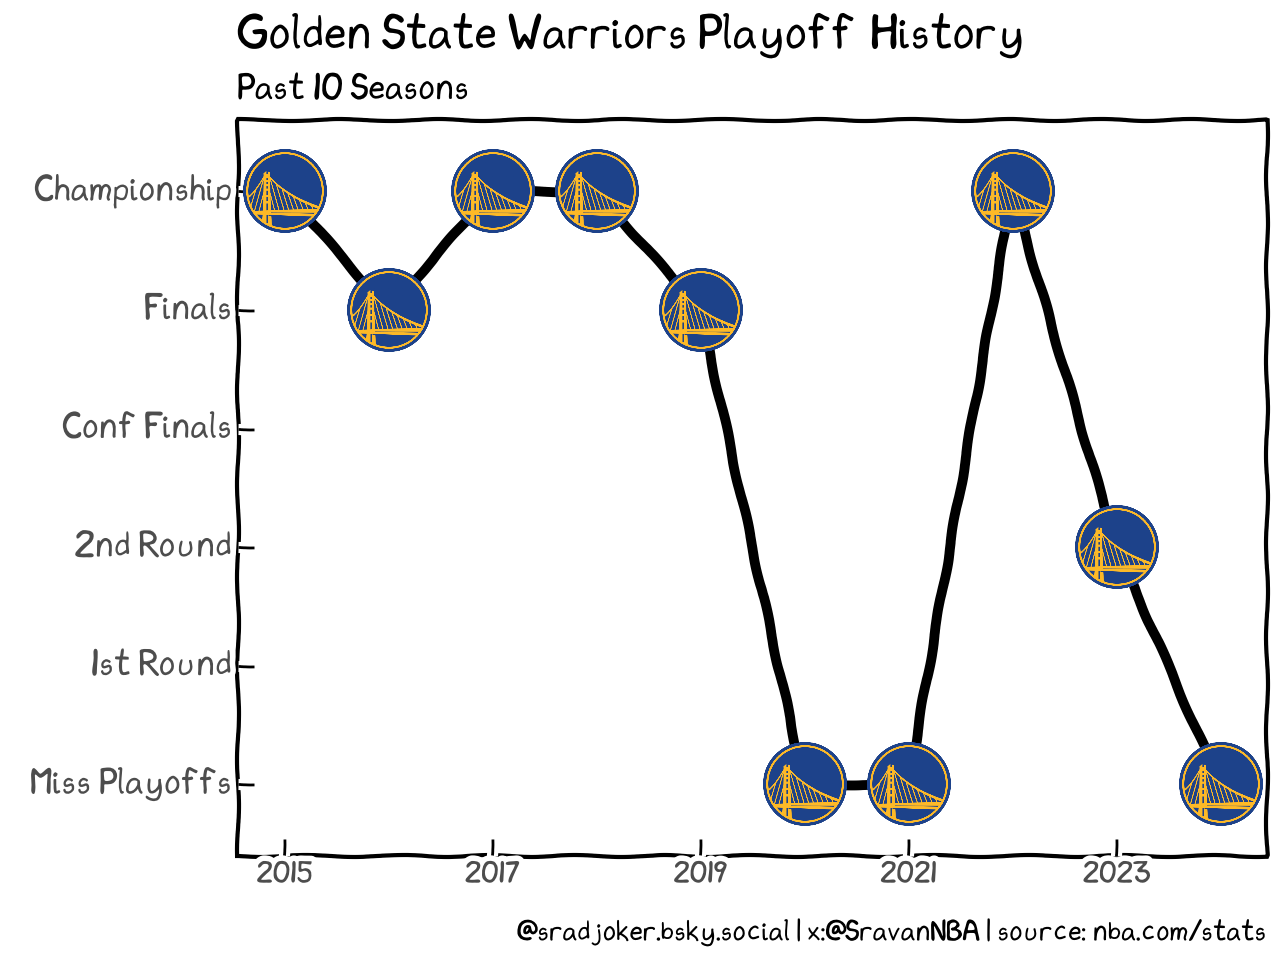

<Figure Size: (640 x 480)>

In [12]:
team = "Golden State Warriors"
data = df11.query(f"TEAM_NAME == '{team}'")
ds = pd.DataFrame({"season":np.arange(2015,2025)})
data = pd.merge(data,ds,how="right")
data["scenario"] = data["scenario"].fillna("Miss Playoffs")
data["round"] = data["scenario"].map(scenario_dict)
data["TEAM_NAME"] = team
data["scenario"] = pd.Categorical(data["scenario"],categories=scenario,ordered=True) 
data["image"]= img_DIR_T + data["TEAM_NAME"] + ".png"
p = (
    ggplot(data)
    + aes(x="season",y="scenario",group="TEAM_NAME",image="image")
    + geom_point()
    + geom_line(size=2)
    + geom_image()
    + scale_y_discrete(drop=False)
    + scale_x_continuous(breaks=np.arange(2015,2024,2))
    + theme_idv
    + theme(
        axis_title_x=element_blank(),
        axis_title_y=element_blank(),
        axis_text_y=element_text(size=12)
    )
    + labs(
        title=f"{team} Playoff History",
        subtitle="Past 10 Seasons",
        caption="bsky:@sradjoker.cc | x:@SravanNBA | source: nba.com/stats"
    )
)
p

In [81]:

data["round"].astype(int).mean()

1.6